# Modification of Example 12.1 Numerical method: FTCS for a spill diffusion problem

In [104]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
H = 1  # water depth, m
W = 60 # width, m

# Remove velocity, so that we can focus on diffusion problem
# U = 2400 # velocity, m/hr
# Q = 144000 # discharge, m^3/hr
E = 150000 # dispersion m^2/hr
Ac = 60 # cross section area, m^2
M = 5 # spill mass, kg
x0 = 500 # spill location, m

In [106]:
def FTCS(xend, tend, dt, dx):
    
    # define location of numerical simulation
    xrange = np.arange(-1000,xend,dx)
    # initial concentration at the spill
    c_spill = M/(Ac*dx)*1000 # kg/m^3 --> mg/L
    # define initial concentration, assign c_spill to the location of the spill
    c0 = np.zeros(len(xrange))
    c0[np.abs(xrange-x0) == min(np.abs(xrange-x0))] = c_spill
    
    lamb = E*dt/dx**2
    
    t = 0
    c_old = c0
    c_new = c0
    while t < tend:
        c_new[1:-1] = lamb * c_old[:-2] + (1-2*lamb) * c_old[1:-1] + lamb * c_old[2:]
        # we should select a far upstream and downstream where the concentration is zero
        c_new[0] = 0
        c_new[-1] = 0
        
        # update time and update concentration for next step
        t = t+dt
        c_old = c_new
        
    return c_new, xrange, lamb

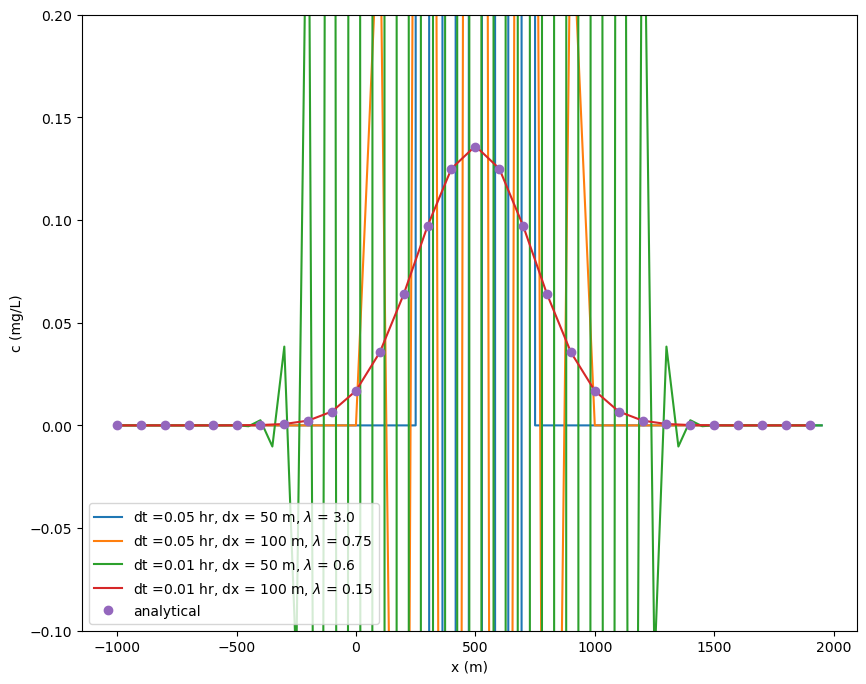

In [107]:
# test the following parameter

xend = 2000
tend = 0.2
dt = [0.05, 0.01]
dx = [50, 100]

plt.figure(figsize=(10,8))
for dti in dt:
    for dxi in dx:
        c, x, lamb = FTCS(xend, tend, dti, dxi)
        plt.plot(x,c,label = 'dt ='+ str(dti) + ' hr, dx = '+str(dxi) + ' m' + ', $\lambda$ = '+str(lamb))
        plt.ylim(-0.1,0.2)
        plt.ylabel('c (mg/L)')
        plt.xlabel('x (m)') 

c_analytical = M*1000/W/np.sqrt(4*np.pi*E*tend) * np.exp(-(x-x0)**2/(4*E*tend))
plt.plot(x, c_analytical,'o',label = 'analytical')
plt.legend()

The above figure shows that only the last choice of $\Delta x$ and $\Delta t$ gives a resaonble estimate of numerical solution. All other cases have an amplified numerical error. This is the stability problem. The stability requirement is $\lambda < 0.5$.

# Example 12.1 Advection-dispersion of a spill

In [129]:
H = 1  # water depth, m
W = 60 # width, m

U = 2400 # velocity, m/hr
Q = 144000 # discharge, m^3/hr
E = 150000 # dispersion m^2/hr
Ac = 60 # cross section area, m^2
M = 5 # spill mass, kg
x0 = 500 # spill location, m

## Determine the segment size and time step

In [130]:
print('maximal segement length should be', 2*E/U, 'm')

maximal segement length should be 125.0 m


In [172]:
# We choose dx = 100 m 
dx = 100
print('stability requires time step smaller than', dx**2/(2*E), 'hr')

stability requires time step smaller than 0.03333333333333333 hr


In [173]:
# Let's choose dt = 0.01 hr
dt = 0.01

## Determine numerical dispersion

In [174]:
En = -U**2*dt/2
print('Numerical dispersion = ', En, 'm^2/hr')
Em = E-En
print('The corrected dispersion = ', Em, 'm^2/hr')

Numerical dispersion =  -28800.0 m^2/hr
The corrected dispersion =  178800.0 m^2/hr


In [183]:
def advection_dispersion(alpha, xend, tend, dt, dx):
    beta = 1-alpha
    # define location of numerical simulation
    xrange = np.arange(0,xend,dx)
    # define initial concentratio
    c0 = np.zeros(len(xrange))
    c0[np.abs(xrange-x0) == min(np.abs(xrange-x0))] = M*1e3/(Ac*dx)
    # There is no loading after the initial spill
    W = np.zeros(len(xrange))

    
    Ep = Em * Ac / dx
    
    t = 0
    c_old = c0
    c_new = c0
    while t < tend:
        c_new[1:-1] = W[1:-1]/(dx*Ac) * dt - dt/(dx*Ac) * (-Q*alpha-Ep) * c_old[:-2] +\
            (1-dt/(dx*Ac)*(-Q*beta+Q*alpha+2*Ep)) * c_old[1:-1] -\
            dt/(dx*Ac)*(Q*beta-Ep) * c_old[2:]
        # we should select a far upstream and downstream where the concentration is zero
        c_new[0] = 0
        c_new[-1] = 0
        
        # update time and update concentration for next step
        t = t+dt
        c_old = c_new
        W = np.zeros(len(xrange))
    return c_new, xrange

Text(0.5, 0, 'x (m)')

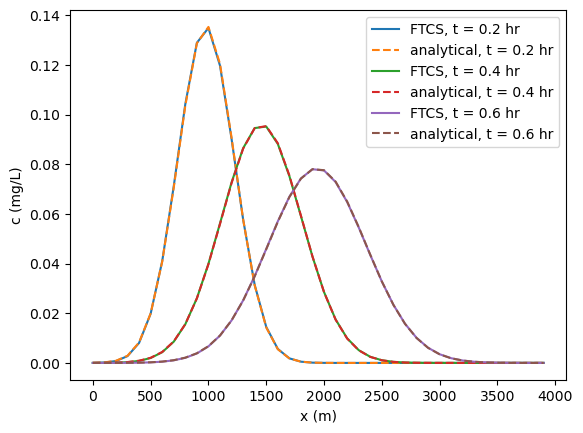

In [184]:
tend = np.array([0.2, 0.4, 0.6])
# Use FTCS: alpha = 0.5
for ti in tend:
    c, x = advection_dispersion(0.5, 4000, ti, dt, dx)
    c_analytical = M*1000/Ac/np.sqrt(4*np.pi*E*ti) * np.exp(-(x-x0-U*ti)**2/(4*E*ti))
    plt.plot(x,c,label='FTCS, t = ' + str(ti)+ ' hr')
    plt.plot(x,c_analytical,'--', label = 'analytical, t = ' + str(ti) + ' hr')
plt.legend() 
plt.ylabel('c (mg/L)')
plt.xlabel('x (m)') 